# 3. Processamento e Pré-processamento de Dados Geoespaciais

> Nesta seção, vamos explorar operações fundamentais de pré-processamento de dados geoespaciais, essenciais para preparar os dados para análises e modelagens mais avançadas. Cada tópico será acompanhado de uma aplicação prática.

## 3.1 Geocoding e Geocoding Reverso
>
> O geocoding é o processo de converter um endereço (como "Cristo Redentor, Rio de Janeiro") em coordenadas geográficas (latitude e longitude). Já o geocoding reverso realiza o caminho oposto: ele transforma coordenadas em um endereço textual.

> ##### Exemplo de Geocoding (endereço -> coordenadas)
>
>> A partir da string `"Cristo Redentor, Rio de Janeiro"` é possível obter a latitude e longitude do Cristo Redentor no Rio de Janeiro

In [1]:
import numpy as np
from geopy.geocoders import Nominatim # Servico de Geocoding fornecido pelo OpenSteetMap

geolocator = Nominatim(user_agent="geoapi") # 
location = geolocator.geocode("Cristo Redentor, Rio de Janeiro")

print("Coordenadas do Cristo Redentor:")
print(f"Latitude: {location.latitude}, Longitude: {location.longitude}")


Coordenadas do Cristo Redentor:
Latitude: -22.9519173, Longitude: -43.2104585


> ##### Exemplo de Geocoding Reverso (coordenadas -> endereço)
>> A partir das coordenadas do Cristo `Latitude: -22.9519173, Longitude: -43.2104585`  é possível obter o endereço aproximado

In [2]:
reverse_location = geolocator.reverse((location.latitude, location.longitude), language="pt")
print("\nEndereço reverso aproximado:")
print(reverse_location.address)


Endereço reverso aproximado:
Cristo Redentor, Estrada do Corcovado, Santa Teresa, Rio de Janeiro, Região Geográfica Imediata do Rio de Janeiro, Região Metropolitana do Rio de Janeiro, Região Geográfica Intermediária do Rio de Janeiro, Rio de Janeiro, Região Sudeste, 22470-180, Brasil


> ##### Plotando Coordenadas em mapas
>> Depois de converter um endereço em coordenadas geográficas (geocoding), podemos plotar o ponto em um mapa usando a biblioteca `folium`.

In [15]:
import folium
m = folium.Map(location=[location.latitude, location.longitude], zoom_start=15)
folium.Marker([location.latitude, location.longitude], popup='Cristo Redentor').add_to(m)
m

>##### `Aplicação: Transformando Endereços em Coordenadas`
>
>Neste exemplo, vamos trabalhar com um dataset real de revenda de apartamentos públicos (HDB flats) em Singapura. A ideia aqui é simples, mas poderosa: **usar localização para encontrar >boas oportunidades de compra**.
>
>Vamos aplicar técnicas geoespaciais simples para entender se um imóvel está caro ou barato comparado à sua vizinhança. Isso pode ser extremamente útil para investidores, compradores ou >até para políticas públicas de habitação.
>
>**Passo a passo:**
>
>- **Geocodificar os endereços**: transformar o endereço dos imóveis em coordenadas geográficas (latitude e longitude) para poder colocá-los no mapa.
>- **Mapear os imóveis no espaço**: visualizar onde estão localizados e associá-los aos bairros ou regiões de interesse.
>- **Analisar a variação de preços por localização**: calcular o valor por metro quadrado e comparar com a média da região para descobrir quais imóveis estão "fora da curva".
>
>> 🔍 *Essa análise ajuda a enxergar padrões que números soltos não mostram — como duas casas com o mesmo preço, mas em contextos bem diferentes.*


Este script automatiza o geocoding de endereços no dataset de imóveis sg-resale-flat-prices-2017-onwards.csv, transformando cada endereço em coordenadas geográficas (latitude e longitude).

Ele é necessario pois como a API do OpenStreetMap limita 60 requisicões por minuto, é necessario pré-processar e criar o dataset em que faremos as analises. 

> *Alem disso, ele que irá "traduzir" os enderecos para coordenadas.*

In [ ]:
import pandas as pd
import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

rodar = False #Coloque True se deseja Rodar o Script

if rodar:
    # Carregar dataset original
    df = pd.read_csv("datasets/Singapore/sg-resale-flat-prices-2017-onwards.csv")

    #Criando uma Coluna 'endereco' com o  bloco + rua, cidade, Singapore
    #Exemplo: "330 SEMBAWANG CL, SEMBAWANG, Singapore"
    df["endereco"] = df["block"] + " " + df["street_name"] + ", " + df["town"] + ", Singapore"
    
    # Geocodificador
    geolocator = Nominatim(user_agent="geoapi_sg_full")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    
    # Tentar carregar resultados anteriores
    try:
        df_geo = pd.read_csv("datasets/Singapore/geocodificados.csv")
        processados = set(df_geo["endereco"])
        print(f"Retomando, {len(processados)} endereços já processados.")
    except FileNotFoundError:
        df_geo = pd.DataFrame()
        processados = set()
    
    novos = []
    batch_size = 50
    pause_seconds = 60
    
    # Iniciar processamento por blocos
    for i, row in df.iterrows():
        endereco = row["endereco"]
        if endereco in processados:
            continue
        
        try:
            location = geocode(endereco)
            lat = location.latitude if location else None
            lon = location.longitude if location else None
        except:
            lat, lon = None, None
    
        # Copiar a linha original e adicionar coordenadas
        nova_linha = row.copy()
        nova_linha["latitude"] = lat
        nova_linha["longitude"] = lon
        novos.append(nova_linha)
    
        print(f"{len(novos)} -> {endereco} => ({lat}, {lon})")
    
        if len(novos) % batch_size == 0:
            df_novos = pd.DataFrame(novos)
            df_geo = pd.concat([df_geo, df_novos], ignore_index=True).drop_duplicates(subset=["endereco"])
            df_geo.to_csv("datasets/Singapore/geocodificados.csv", index=False)
            print(f"📝 Salvo após {len(novos)} registros.")
            novos.clear()
            print(f"⏸️ Pausando por {pause_seconds} segundos...")
            time.sleep(pause_seconds)
    
    # Salvar o restante
    if novos:
        df_novos = pd.DataFrame(novos)
        df_geo = pd.concat([df_geo, df_novos], ignore_index=True).drop_duplicates(subset=["endereco"])
        df_geo.to_csv("datasets/Singapore/geocodificados.csv", index=False)
        print("✅ Processamento finalizado.")
    

> Agora, Com o dataset 'geocodificados.csv' já é possivel montar um simples Mapa Com os pontos desses imoveis

In [34]:
# Carregar os dados ja pre-processados 
df = pd.read_csv("datasets/Singapore/geocodificados.csv")

# Amostrar para testes rápidos
df_amostra = df.sample(n=30, random_state=42).copy()
df = df.dropna()
m = folium.Map(location=[1.3521, 103.8198], zoom_start=12, tiles="CartoDB dark_matter")

folium.GeoJson(
    "datasets/Singapore/singapore_boundary.geojson",  
    name="Limite de Singapura",
    style_function=lambda feature: {
        "color": "#2c7fb8",         # azul mais suave
        "weight": 1,
        "fillColor": "#a6bddb",
        "fillOpacity": 0.2

    }
).add_to(m)

for _, row in df.iterrows():
    endereco = row["endereco"]
    popup_text = f"<b>Endereço:</b> {endereco}<br>"
    
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=6,
        color='white',
        fill_color='green',
        fill=True,
        fill_opacity=0.75,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(m)



# Adicionar controle de camadas
folium.LayerControl().add_to(m)

m

#####  `Mapa Interativo: Distribuição Espacial dos Preços por m²`

>| Faixa | Critério | Cor |
>|-------|----------|-----|
>| **Barato** | Preço/m² abaixo do 1º quartil (Q1) | 🟢 Verde |
>| **Na média** | Entre Q1 e Q3 (mediana) | 🟠 Laranja |
>| **Caro** | Acima do 3º quartil (Q3) | 🔴 Vermelho |

In [39]:
import folium
from folium.plugins import MarkerCluster

# Calcular o preço por m²
df["preco_m2"] = df["resale_price"] / df["floor_area_sqm"]

# Calcular quartis
q1 = df["preco_m2"].quantile(0.25)
q3 = df["preco_m2"].quantile(0.75)

# Função de cor baseada nos quartis
def cor_por_preco_m2(valor):
    if valor < q1:
        return "green"
    elif valor > q3:
        return "red"
    else:
        return "orange"

# Criar o mapa
m = folium.Map(location=[1.3521, 103.8198], zoom_start=12, tiles="CartoDB positron")

# Adicionar camada com o limite de Singapura
folium.GeoJson(
    "datasets/Singapore/singapore_boundary.geojson",  
    name="Limite de Singapura",
    style_function=lambda feature: {
        "color": "#2c7fb8",
        "weight": 1,
        "fillColor": "#a6bddb",
        "fillOpacity": 0.2
    }
).add_to(m)


# Adicionar marcadores ao cluster
for _, row in df.iterrows():
    preco_total = row["resale_price"]
    preco_m2 = row["preco_m2"]
    popup_text = (
        f"<b>Preço total:</b> ${preco_total:,.0f}<br>"
        f"<b>Área:</b> {row['floor_area_sqm']} m²<br>"
        f"<b>Preço/m²:</b> ${preco_m2:,.0f}<br>"
        f"<b>Tipo:</b> {row['flat_type']}"
    )
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=6,
        color="black",  # contorno
        fill=True,
        fill_color=cor_por_preco_m2(preco_m2),
        fill_opacity=0.85,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(m)

# Controles
folium.LayerControl().add_to(m)

print(f"{len(df)} imóveis plotados com cores baseadas em preço/m².")
m


1404 imóveis plotados com cores baseadas em preço/m².


##### `Conclusão`

> Com base apenas nos endereços textuais, conseguimos:
> 
>> - Localizar imóveis no mapa
>> - Visualizar a distribuição espacial dos preços
>> - Preparar os dados para análises 
> 
> Isso mostra como **geocoding é uma ponte entre dados tradicionais e análises espaciais**.


## 3.2 Projeções Cartográficas

>  Projeções cartográficas são transformações matemáticas que convertem a superfície curva da Terra (esferoide) em uma superfície plana (mapa). Como não é possível representar  > perfeitamente uma esfera em um plano, cada projeção faz **compromissos entre preservar forma, área, distância ou direção**.


> ### Por que isso importa?
>  
>  Para muitas análises espaciais — como **cálculo de área, distância entre pontos, buffers e rotas** — é essencial que os dados estejam em uma **projeção apropriada**. A maioria dos  > dados geográficos brutos vem no sistema **WGS84** (EPSG:4326), que usa latitude e longitude (graus), mas não é adequado para medições métricas.
>  
>  ### 🌎 Exemplos de Projeções
>  
>  - **WGS84 (EPSG:4326)**: padrão global, usa graus. Bom para visualização, ruim para cálculos.
>  - **UTM (Universal Transverse Mercator)**: divide o globo em zonas com projeção métrica, ideal para cálculos de distância e área em regiões menores.
>  - **Albers Equal Area**: preserva área, útil para análise de distribuição espacial em grandes regiões.
>  
>  
>  **Aplicação:** Transformar um dataset de coordenadas geográficas (WGS84) para projeção métrica (UTM), facilitando o cálculo de distâncias reais.

In [7]:
import geopandas as gpd

# Carregando shapefile dos municípios do RJ
shapefile_path = "datasets/RJ_2023/RJ_Municipios_2023.shp"
gdf = gpd.read_file(shapefile_path)

# Selecionar apenas um município (por exemplo, Rio de Janeiro)
rio = gdf[gdf["NM_MUN"] == "Rio de Janeiro"]

# Calcular área no sistema WGS84 (em graus) – NÃO CONFIÁVEL!
area_wgs84 = rio.geometry.area.iloc[0]

# Agora convertemos para UTM zona 23S (projeção métrica adequada)
rio_utm = rio.to_crs(epsg=31983)

# Calcular área no sistema UTM (em metros quadrados) – CONFIÁVEL!
area_utm = rio_utm.geometry.area.iloc[0]

# Mostrar os resultados
print(f"Área no sistema WGS84 (graus²): {area_wgs84}")
print(f"Área no sistema UTM (m²): {area_utm:,.2f}")
print(f"Área no sistema UTM (km²): {area_utm/1e6:,.2f}")


Área no sistema WGS84 (graus²): 0.1056623137465809
Área no sistema UTM (m²): 1,200,125,190.48
Área no sistema UTM (km²): 1,200.13


C:\Users\PC\AppData\Local\Temp\ipykernel_26828\1047340510.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_wgs84 = rio.geometry.area.iloc[0]


### Conclusão:
- O valor em graus quadrados não tem interpretação prática direta — ele depende da curvatura da Terra e da latitude!

- Já o valor em metros quadrados, obtido com uma projeção como UTM, é o que você precisa para:

  - Calcular densidade populacional

  - Estimar área útil de uma zona

  - Fazer modelagem espacial confiável

🔗 Se você errar a projeção, você compromete os resultados do modelo!

## 3.3 Interseções de Camadas Geoespaciais

> Uma das operações mais poderosas em ciência de dados geoespaciais é a **interseção entre camadas (layers)**. Essa técnica permite responder a perguntas espaciais complexas, como:
> 
> - 🏥 Quais hospitais estão em áreas de risco ambiental?
> - 🌳 Quais bairros têm escolas dentro de zonas verdes?
> - 🚨 Quais ocorrências policiais aconteceram dentro de determinada região?
> 
> Essas respostas emergem ao **cruzar diferentes fontes de dados espaciais** — como a sobreposição de **pontos, linhas e polígonos** com camadas raster (como imagens de satélite ou dados > climáticos).


### ⚡ Substituição de Usinas Fósseis por Energia Solar: Análise Espacial

Neste notebook, realizamos uma análise baseada em dados reais para avaliar o **potencial de substituição de usinas fósseis por energia solar no Brasil**.

A lógica é:
- Ver **onde as usinas fósseis estão localizadas**
- Verificar se essas regiões têm **alto potencial solar (PVOUT)**
- Calcular se seria **energeticamente viável substituir** a geração dessas usinas por usinas solares

C:\Users\PC\AppData\Local\Temp\ipykernel_26828\3652090385.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  usinas = pd.read_csv('datasets/solar_potential/globalpowerplantdatabasev130/global_power_plant_database.csv')


(74, 38)
     country country_long                                               name  \
1157     BRA       Brazil                                AMBEV - João Pessoa   
1162     BRA       Brazil                            Abatedouro São Salvador   
1169     BRA       Brazil  Aeroporto Internacional Pinto Martins - Termin...   
1172     BRA       Brazil                Aeroporto Internacional de Brasília   
1220     BRA       Brazil                                              Altos   

       gppd_idnr  capacity_mw  latitude  longitude primary_fuel other_fuel1  \
1157  BRA0030050        1.350   -7.1110   -34.8536          Oil         NaN   
1162  BRA0028991        3.688  -16.0044   -49.7867          Oil         NaN   
1169  BRA0029304        1.080   -3.7737   -38.5321          Oil         NaN   
1172  BRA0029569        2.420  -15.8627   -47.9072          Oil         NaN   
1220  BRA0028538       13.120   -5.0321   -42.4358          Oil         NaN   

     other_fuel2  ... estimated_gen

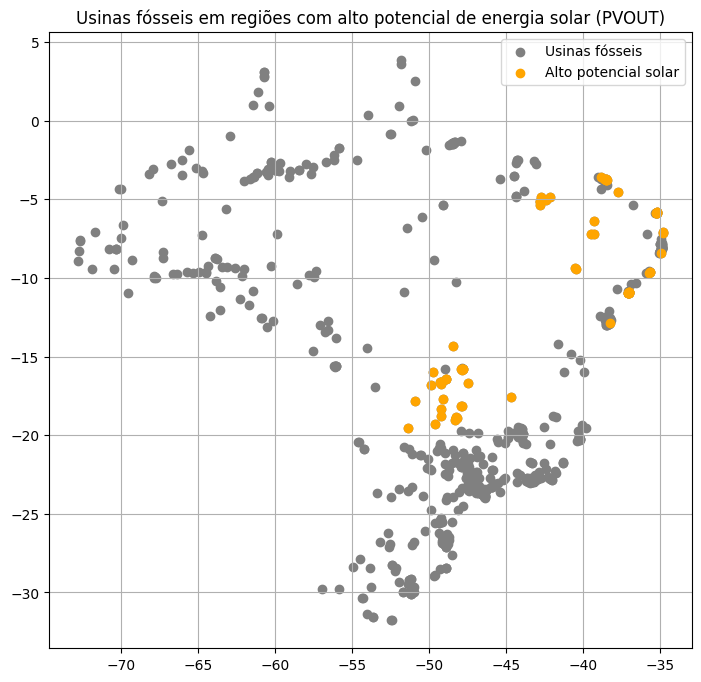

In [8]:
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Carregar dados das usinas fósseis no Brasil
usinas = pd.read_csv('datasets/solar_potential/globalpowerplantdatabasev130/global_power_plant_database.csv')
usinas_br = usinas[(usinas.country_long == "Brazil") & 
                   (usinas.primary_fuel.isin(["Coal", "Gas", "Oil"]))]

# Converter em GeoDataFrame
geometry = [Point(xy) for xy in zip(usinas_br.longitude, usinas_br.latitude)]
gdf = gpd.GeoDataFrame(usinas_br, geometry=geometry, crs="EPSG:4326")

# Carregar raster PVOUT
raster = rasterio.open("datasets\solar_potential\World_PVOUT_GISdata_LTAy_AvgDailyTotals_GlobalSolarAtlas-v2_GEOTIFF\World_PVOUT_GISdata_LTAy_DailySum_GlobalSolarAtlas_GEOTIFF\PVOUT.tif")

# Extrair valores de PVOUT para cada usina
coords = [(geom.x, geom.y) for geom in gdf.geometry]
pvout_values = [val[0] for val in raster.sample(coords)]
gdf["pvout"] = pvout_values

# Filtrar por alto potencial solar
gdf_altas = gdf[gdf["pvout"] > 4.6]  # limite ajustável
print(gdf_altas.shape)
print(gdf_altas.head())

# Visualização
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color="gray", label="Usinas fósseis")
gdf_altas.plot(ax=ax, color="orange", label="Alto potencial solar")
plt.title("Usinas fósseis em regiões com alto potencial de energia solar (PVOUT)")
plt.legend()
plt.grid(True)
plt.show()

## 3.4 Interpolação Espacial (Kriging)

### 📌 O problema

Imagine que você possui medições de temperatura do fundo do mar feitas por sensores em pontos esparsos. Você quer criar um **mapa contínuo** para visualizar a variação da temperatura ao longo de toda a região.

Para isso, usamos **interpolação espacial** — uma técnica que estima valores em locais onde não há dados, com base na localização e valor dos pontos conhecidos.


### 🔄 Comparando abordagens

| Método | Como funciona | Limitações |
|--------|----------------|-------------|
| **IDW** (Inverse Distance Weighting) | A média ponderada dos pontos vizinhos, com pesos baseados na distância (“pontos mais próximos são mais parecidos”) | Não considera padrões espaciais complexos, só a distância |
| **Kriging** | Ajusta um modelo estatístico (variograma) para estimar valores com base na **estrutura espacial do dado** | Mais complexo, exige ajuste de modelo e interpretação mais técnica |


### 🧠 O que é o Kriging?

Kriging é uma técnica de interpolação **baseada em modelos estatísticos** que incorporam:

- A **distância** entre os pontos
- A **variabilidade dos dados**
- A **direção ou tendência** dos dados (em versões mais avançadas)

Ideal para fenômenos naturais como temperatura, poluição, teor de minério, etc.


In [9]:
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import griddata
# Recarregar o CSV pulando a linha com as unidades
df = pd.read_csv("datasets/temp_sea_bottom/northeast_atlatic_sea_bottom_temp.csv")
# Garantir conversão correta para tipos numéricos
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["sea_bottom_temperature"] = pd.to_numeric(df["sea_bottom_temperature"], errors="coerce")

# Remover linhas com valores faltantes
df = df.dropna(subset=["latitude", "longitude", "sea_bottom_temperature"])

# Exibir preview
df.head()


time  latitude  longitude  sea_bottom_temperature
0  2017-11-30T00:00:00Z  48.00625  -17.99375                2.149733
1  2017-11-30T00:00:00Z  48.00625  -17.98125                2.149733
2  2017-11-30T00:00:00Z  48.00625  -17.96875                2.149733
3  2017-11-30T00:00:00Z  48.00625  -17.95625                2.149733
4  2017-11-30T00:00:00Z  48.00625  -17.94375                2.172670

In [10]:

# Amostrar 500 pontos para agilizar a krigagem
df_sample = df.sample(n=1000, random_state=42)

# Extrair variáveis
x = df_sample["longitude"].values
y = df_sample["latitude"].values
z = df_sample["sea_bottom_temperature"].values


In [11]:
# Interpolação com IDW usando griddata
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

zi_idw = griddata((x, y), z, (grid_x, grid_y), method='linear')


In [12]:
# Interpolação com Kriging
OK = OrdinaryKriging(x, y, z, variogram_model='linear', verbose=False, enable_plotting=False)
zi_krig, _ = OK.execute("grid", grid_x[0], grid_y[:, 0])


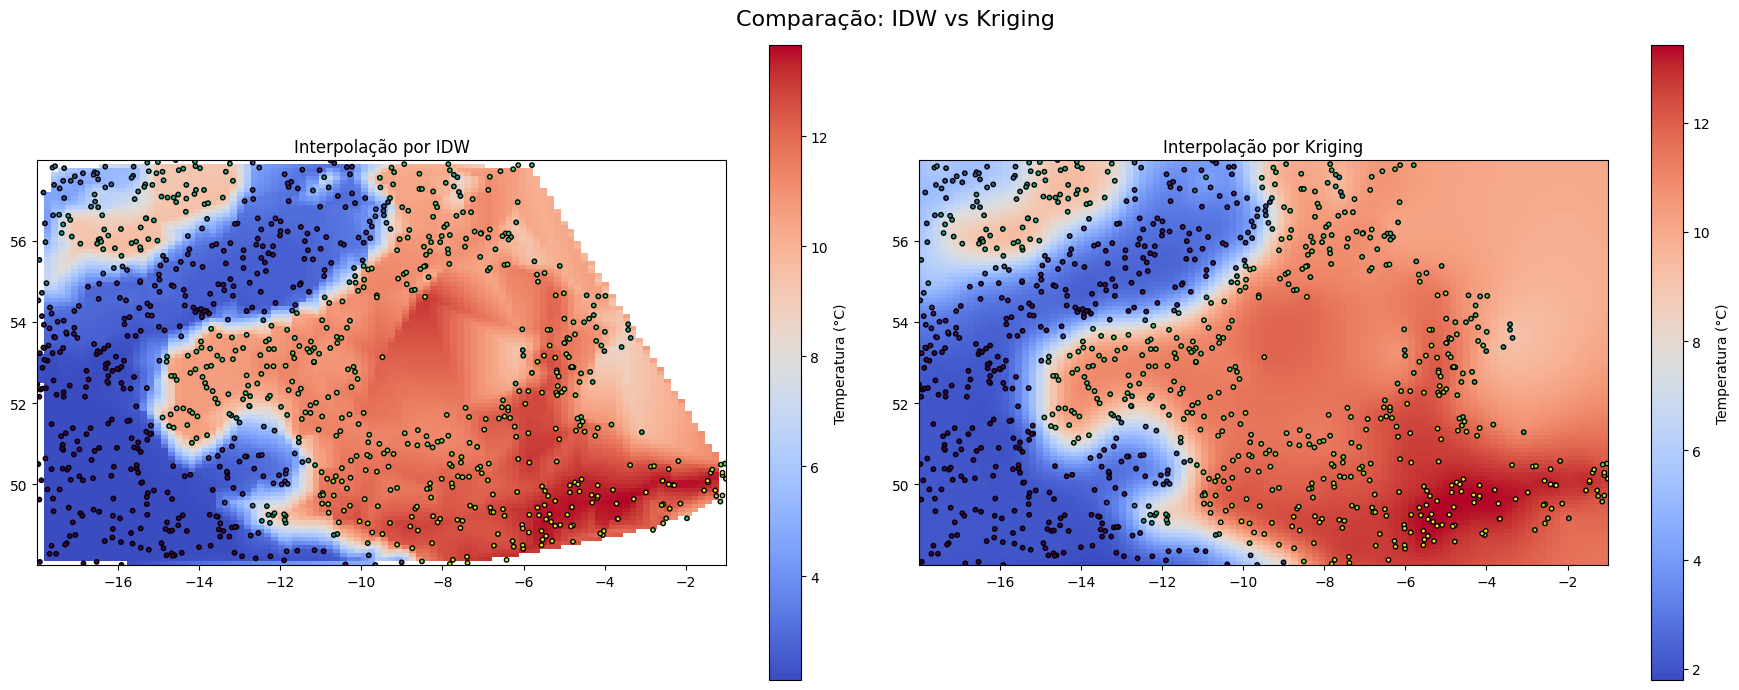

In [ ]:
# Comparação visual
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# IDW
im1 = axs[0].imshow(zi_idw, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='coolwarm')
axs[0].set_title("Interpolação por IDW")
axs[0].scatter(x, y, c=z, edgecolors='k', s=10)
plt.colorbar(im1, ax=axs[0], label="Temperatura (°C)")

# Kriging
im2 = axs[1].imshow(zi_krig, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='coolwarm')
axs[1].set_title("Interpolação por Kriging")
axs[1].scatter(x, y, c=z, edgecolors='k', s=10)
plt.colorbar(im2, ax=axs[1], label="Temperatura (°C)")

plt.suptitle("Comparação: IDW vs Kriging", fontsize=16)
plt.tight_layout()
plt.show()
